# Virtualizing Packet-Processing Network Functions over Heterogeneous OpenFlow Switches - Graphics

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
import re
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
tempos = ["010", "020", "030"]
tempoEstavel = 100
seeds = ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150"]
quantidadeIperfs = 2500
salvarGraficos = False
intervalosEstaveis = [("010", 28, 48), ("020", 38, 58), ("030", 48, 68)]
intervalosTempo = [("010", 150, 250), ("020", 200, 300), ("030", 250, 350)]
confianca = 95

In [3]:
#Adicionando colunas com a medicao
mHW = 0
mSW = 0
def teste (nomeSwitch):
    global mHW
    global mSW
    if (nomeSwitch == "HW"):
        mHW += 1
        return mHW
    if (nomeSwitch == "SW"):
        mSW += 1
        return mSW

#Lendo os arquivos info (report do controlador)
dfPI_info = pd.DataFrame()
dfSW_info = pd.DataFrame()
i = 1
for seed in seeds:
    mHW = 0
    mSW = 0
    for tempo in tempos:
        mHW = 0
        mSW = 0
        dfPI_infoTemp = pd.read_csv("../Files/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_infoTemp['TempoChegada'] = tempo
        dfPI_infoTemp['Seed'] = seed
        dfPI_infoTemp['Política'] = 'Static'
        dfPI_infoTemp['Medicao'] = dfPI_infoTemp['Switch'].apply(teste)
        dfPI_info = pd.concat([dfPI_info, dfPI_infoTemp], ignore_index=True)
        mHW = 0
        mSW = 0
        dfSW_infoTemp = pd.read_csv("../Files/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_infoTemp['TempoChegada'] = tempo
        dfSW_infoTemp['Seed'] = seed
        dfSW_infoTemp['Política'] = 'Dynamic'
        dfSW_infoTemp['Medicao'] = dfSW_infoTemp['Switch'].apply(teste)
        dfSW_infoTemp.rename(columns={'VezesBloqueado':'RegrasBloqueadas'}, inplace=True)
        dfSW_info = pd.concat([dfSW_info, dfSW_infoTemp], ignore_index=True)
    i += 1
dfTotal_info = pd.concat([dfPI_info, dfSW_info], ignore_index=True)

In [4]:
#Lendo todos os CSVs dos iperfs
dfPI_csv = pd.DataFrame()
dfSW_csv = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_csvTemp = pd.read_csv("../Files/teste"+(str(i))+"_pi"+(tempo)+"/teste"+(str(i))+"_pi"+(tempo)+".csv")
        dfPI_csvTemp['TempoChegada'] = tempo
        dfPI_csvTemp['Seed'] = seed
        dfPI_csvTemp['Política'] = 'PI'
        dfPI_csv = pd.concat([dfPI_csv, dfPI_csvTemp], ignore_index=True)
        dfSW_csvTemp = pd.read_csv("../Files/teste"+(str(i))+"_sw"+(tempo)+"/teste"+(str(i))+"_sw"+(tempo)+".csv")
        dfSW_csvTemp['TempoChegada'] = tempo
        dfSW_csvTemp['Seed'] = seed
        dfSW_csvTemp['Política'] = 'SW'
        dfSW_csv = pd.concat([dfSW_csv, dfSW_csvTemp], ignore_index=True)
    i += 1
del dfPI_csv['?']
del dfSW_csv['?']
del dfSW_csv['Timestamp']
del dfPI_csv['Timestamp']
dfServerPI = dfPI_csv[dfPI_csv.IpOri == '10.1.0.1']
dfServerSW = dfSW_csv[dfSW_csv.IpOri == '10.1.0.1']
dfServer = pd.concat([dfServerPI, dfServerSW], ignore_index=True)

## Blocking percentage graph in static policy

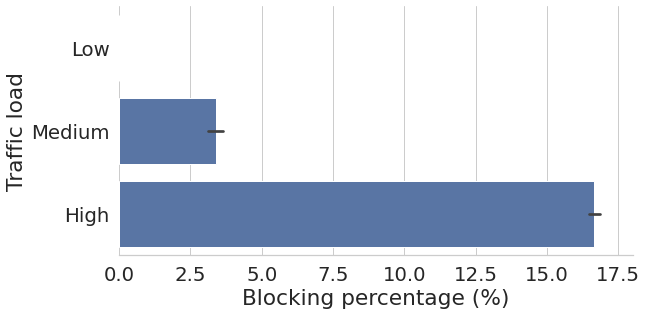

In [5]:
#Grafico de bloqueados metodo par impar
gpb = dfTotal_info.groupby(["Seed", "TempoChegada", "Política"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(quantidadeIperfs)*100
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "High", "020": "Medium", "030": "Low"})
sns_plt = sns.catplot(legend=False, height=4.5, aspect=2, x="TaxaBloqueio", y="NomeTempo", kind="bar", orient="h", hue="Política", hue_order=["Static"],order=["Low", "Medium", "High"], ci=confianca, data=gpb)
#sns_plt.fig.suptitle('Taxa de bloqueio por carga', y=1.05)
sns_plt.set(xlim=(0, 18))
sns_plt.set_axis_labels("Blocking percentage (%)","Traffic load")
sns_plt.despine(left=True)
if (salvarGraficos):
    sns_plt.savefig("Graficos/TaxaBloqueio.pdf")

In [6]:
#Trafego em cada switch no intervalo estavel
def func(g):
    return g
gpb = dfTotal_info.groupby(["Política", "TempoChegada", "Switch", "Medicao", "Seed"]).apply(func)
gpb['Total'] = 0
gpb.reset_index(inplace=True)
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and (row['Medicao'] != b and row['Medicao'] != c)):
            gpb.drop(index, inplace=True)
#Calculando o total transmitido no intervalo estavel
#(bytesenviados no fim-inicio porque bytesenviados é acumulativo)
totalHW = 0
totalSW = 0
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "HW"):
            totalHW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "HW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalHW
            totalHW = 0
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "SW"):
            totalSW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "SW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalSW
            totalSW = 0
gpb = gpb[gpb.Total != 0]

## Aggregate throughput graph on each switch in both policies

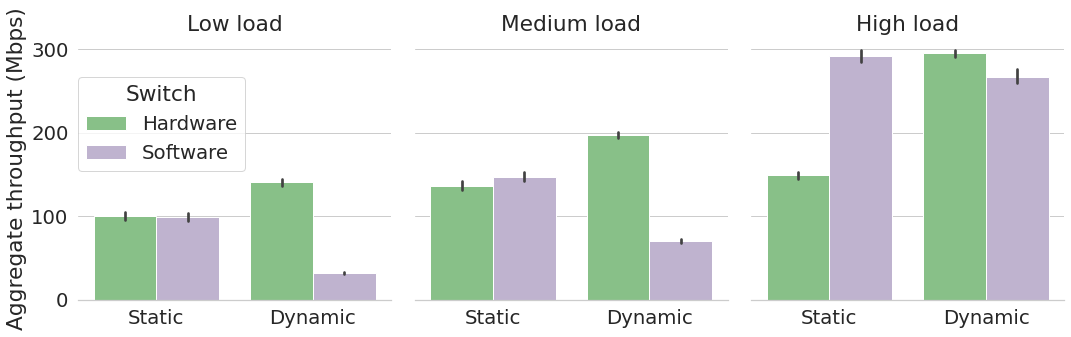

In [7]:
#Plotando grafico
gpb["MbSeg"] = gpb["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb["NomeSwitch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "High", "020": "Medium", "030": "Low"})
sns_plt = sns.catplot(palette="Accent", x="Política", y="MbSeg", kind="bar", ci=confianca, data=gpb, col="NomeTempo", hue="NomeSwitch", col_order=["Low", "Medium", "High"], order=["Static", "Dynamic"])
#sns_plt.set(ylim=(0, 350))
#sns_plt.fig.suptitle('Vazão Medium no intervalo estável', y=1.05)
sns_plt.set_axis_labels("", "Aggregate throughput (Mbps)")
sns_plt.set_titles("{col_name} load")
sns_plt._legend.set_title("Switch")
sns_plt.despine(left=True)
leg = sns_plt._legend
leg.set_bbox_to_anchor([0.055, 0.75])
leg._loc = 2
leg.set_frame_on(True)
if (salvarGraficos):
    sns_plt.savefig("Graficos/VazaoMediaIntervaloEstavelPorSwitch.pdf")

## Aggregate throughput graph on each policy

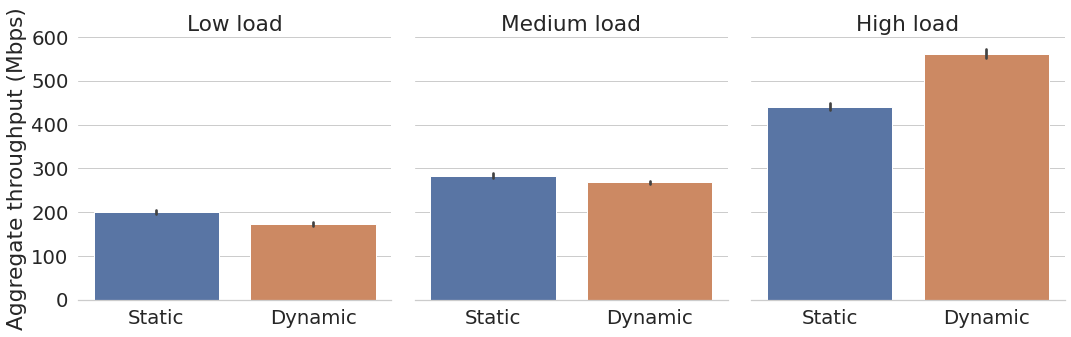

In [8]:
gpb2 = gpb.groupby(["Política", "TempoChegada", "Seed"]).sum()
gpb2["MbSeg"] = gpb2["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb2.reset_index(inplace=True)
gpb2["NomeTempo"] = gpb2["TempoChegada"].map({"010": "High", "020": "Medium", "030": "Low"})
sns_plt = sns.catplot(x="Política", y="MbSeg", kind="bar", ci=confianca, data=gpb2, col="NomeTempo", col_order=["Low", "Medium","High"], order=["Static", "Dynamic"])
sns_plt.set(ylim=(0, 600))
#sns_plt.fig.suptitle('Vazão Medium por método no intervalo estável', y=1.05)
sns_plt.set_axis_labels("", "Aggregate throughput (Mbps)")
sns_plt.set_titles("{col_name} load")
sns_plt.despine(left=True)
if (salvarGraficos):
    sns_plt.savefig("Graficos/VazaoIntervaloEstavelPorMetodo.pdf")

In [9]:
#Pegando intervalo estavel para media de regras instaladas
gpb3 = dfTotal_info.groupby(["Política", "Medicao", "TempoChegada", "Switch", "Seed"]).mean()
gpb3.reset_index(inplace=True)
for index, row in gpb3.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and (row['Medicao'] < b or row['Medicao'] > c)):
            gpb3.drop(index, inplace=True)
gpb3 = gpb3.groupby(["Política", "Switch", "TempoChegada", "Seed"]).mean()
gpb3.reset_index(inplace=True)
gpb3["NomeSwitch"] = gpb3["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb3["NomeTempo"] = gpb3["TempoChegada"].map({"010": "High", "020": "Medium", "030": "Low"})

## Graph of number of rules installed on each switch in both policies 

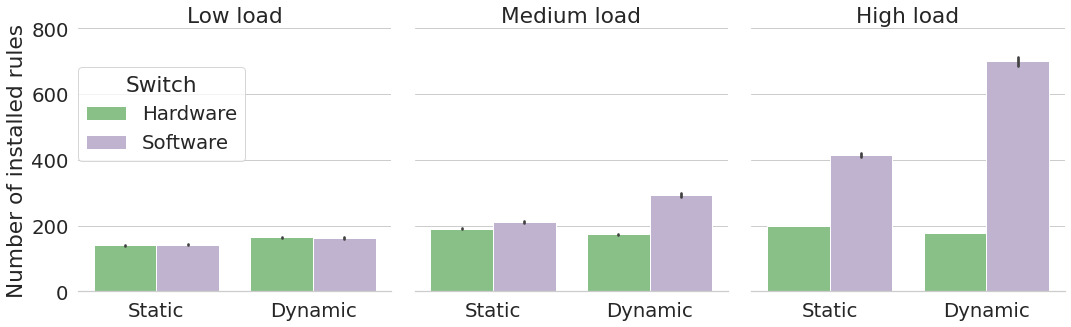

In [10]:
#Plotando o grafico
sns_plt = sns.catplot(palette="Accent", x="Política", y="RegrasInstaladas", kind="bar", ci=confianca, data=gpb3, col="NomeTempo", hue="NomeSwitch", col_order=["Low", "Medium", "High"], order=["Static", "Dynamic"])
sns_plt.set(ylim=(0, 800))
#sns_plt.fig.suptitle('Medium de regras instaladas por switch no intervalo estável', y=1.05)
sns_plt.set_axis_labels("", "Number of installed rules")
sns_plt.set_titles("{col_name} load")
sns_plt._legend.set_title("Switch")
sns_plt.despine(left=True)
leg = sns_plt._legend
leg.set_bbox_to_anchor([0.055, 0.75])
leg._loc = 2
leg.set_frame_on(True)
if (salvarGraficos):
    sns_plt.savefig("Graficos/MediaRegrasInstaladas.pdf")

## Table with the number of packages out of order

In [11]:
#Pegando portas no intervalo estavel
dfIperf = pd.DataFrame()
for i in range(len(seeds)):
    dfIperf_temp = pd.read_csv("../Files/teste"+(str(i+1))+"_pi010/iperfs.txt", sep="\t")
    dfIperf_temp['Seed'] = seeds[i]
    dfIperf = pd.concat([dfIperf, dfIperf_temp], ignore_index=True)
portasEstaveis010 = []
portasEstaveis020 = []
portasEstaveis030 = []
for a, b, c in intervalosTempo:
    for index, row in dfIperf.iterrows():
        if (row['Inicio(seg)'] >= b and row['Inicio(seg)'] <= c):
            if (a == "010"):
                portasEstaveis010.append(int(row['PCli']))
            elif (a == "020"):
                portasEstaveis020.append(int(row['PCli']))
            elif (a == "030"):
                portasEstaveis030.append(int(row['PCli']))

#Remove os duplicados das listas
def remove_duplicados(lista_duplicada): 
    lista = [] 
    for porta in lista_duplicada:
        if porta not in lista:
            lista.append(porta) 
    return lista

portasEstaveis010 = remove_duplicados(portasEstaveis010)
portasEstaveis020 = remove_duplicados(portasEstaveis020)
portasEstaveis030 = remove_duplicados(portasEstaveis030)

In [12]:
gpb = dfServer.groupby(["Política", "PortaOri", "PortaDest", "TempoChegada"]).mean()
gpb.reset_index(inplace=True)
dfEstavel = gpb
for index, row in gpb.iterrows():
    if (not(int(row['PortaDest']) in portasEstaveis010) and row['TempoChegada'] == "010"):
        dfEstavel.drop(index, inplace=True)
    elif (not(int(row['PortaDest']) in portasEstaveis020) and row['TempoChegada'] == "020"):
        dfEstavel.drop(index, inplace=True)
    elif (not(int(row['PortaDest']) in portasEstaveis030) and row['TempoChegada'] == "030"):
        dfEstavel.drop(index, inplace=True)

In [13]:
#Pacotes fora de ordem no intervalo estavel
dfServer['%ForaOrdem'] = dfServer['ForaOrdem']/(dfServer['PctEnv']-dfServer['PctPerdido'])
#dfServer.head()
#Carga High
print ("High load:")
inicio = np.min(portasEstaveis010)
fim = np.max(portasEstaveis010)
gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '010'")
min = gpb.groupby("Política").min()['%ForaOrdem']
med = gpb.groupby("Política").mean()['%ForaOrdem']
max = gpb.groupby("Política").max()['%ForaOrdem']
medi = gpb.groupby("Política").median()['%ForaOrdem']
table = [min, med, medi, max]
rowIDs = ["Minumum", "Average", "Median", "Maximum"]
print(tabulate(table, showindex=rowIDs, tablefmt="grid"))

#Carga media
print ("\n\Medium load:")
inicio = np.min(portasEstaveis020)
fim = np.max(portasEstaveis020)
gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '020'")
min = gpb.groupby("Política").min()['%ForaOrdem']
med = gpb.groupby("Política").mean()['%ForaOrdem']
max = gpb.groupby("Política").max()['%ForaOrdem']
medi = gpb.groupby("Política").median()['%ForaOrdem']
table = [min, med, medi, max]
rowIDs = ["Minumum", "Average", "Median", "Maximum"]
print(tabulate(table, showindex=rowIDs, tablefmt="grid"))

#Carga Low
print ("\n\nLow load:")
inicio = np.min(portasEstaveis030)
fim = np.max(portasEstaveis030)
gpb = dfServer.query("PortaDest >= @inicio and PortaDest <= @fim and TempoChegada == '030'")
min = gpb.groupby("Política").min()['%ForaOrdem']
med = gpb.groupby("Política").mean()['%ForaOrdem']
max = gpb.groupby("Política").max()['%ForaOrdem']
medi = gpb.groupby("Política").median()['%ForaOrdem']
table = [min, med, medi, max]
rowIDs = ["Minumum", "Average", "Median", "Maximum"]
print(tabulate(table, showindex=rowIDs, tablefmt="grid"))

High load:
+---------+-------------+-------------+
| Minumum | 0           | 0           |
+---------+-------------+-------------+
| Average | 4.62034e-07 | 1.28167e-05 |
+---------+-------------+-------------+
| Median  | 0           | 0           |
+---------+-------------+-------------+
| Maximum | 0.0010101   | 0.0288462   |
+---------+-------------+-------------+

\Medium load:
+---------+-------------+---+
| Minumum | 0           | 0 |
+---------+-------------+---+
| Average | 4.88382e-08 | 0 |
+---------+-------------+---+
| Median  | 0           | 0 |
+---------+-------------+---+
| Maximum | 0.000395101 | 0 |
+---------+-------------+---+


Low load:
+---------+---+---+
| Minumum | 0 | 0 |
+---------+---+---+
| Average | 0 | 0 |
+---------+---+---+
| Median  | 0 | 0 |
+---------+---+---+
| Maximum | 0 | 0 |
+---------+---+---+


## Delay graph on each switch at high load

In [14]:
#Lendo os arquivos de ping
def pings(dfP, metodo, switch):
    for s in range(len(seeds)):
        for tempo in tempos:
            path = "../Files/teste"+(str(s+1))+"_"+(metodo)+(tempo)+"/ping"+switch+".txt" #caminho do arquivo
            with open(path) as stream:#Abre o arquivo
                times = [] #lista que armazenara todos os pings para coloca-los posteriormente em um series->dataframe
                next(stream)  # Ignora a primeira linha do arquivo de entrada
                for line in stream: #Pega todas as linhas
                    string = line.split(" ") #String eh uma lista com cada palavra da linha
                    if(line != "Request timed out\n"): #Se a linha tiver o ping
                        for i in range(0,len(string)): #Para cada palavra na lista string, procura "time"
                            if(re.match(r'time', string[i])): #Pega somente os valores numericos da palavra
                                time = re.findall(r'\d.+', string[i])
                                times.append(float(time[0])) #Transforma-os para float e coloca-os na lista times
                series = pd.Series(times) #Transforma a lista em uma Series
                ds = pd.DataFrame(series, columns=['Ping']) # E por fim em um dataframe
                ds['Seed'] = seeds[s]
                ds['Tempo'] = tempo
                ds['Política'] = metodo
                ds['Switch'] = switch
                dfP = pd.concat([dfP, ds])
    return dfP

dfPing = pd.DataFrame(columns=['Ping', 'Seed', 'Tempo', 'Política', 'Switch'])
dfPPIHW = pings(dfPing, 'pi', 'HW')
dfPPISW = pings(dfPing, 'pi', 'SW')
dfPSWHW = pings(dfPing, 'sw', 'HW')
dfPSWSW = pings(dfPing, 'sw', 'SW')
dfPing = pd.concat([dfPing, dfPPIHW, dfPPISW, dfPSWHW, dfPSWSW])
dfPing.reset_index(inplace=True)
del dfPing['index']

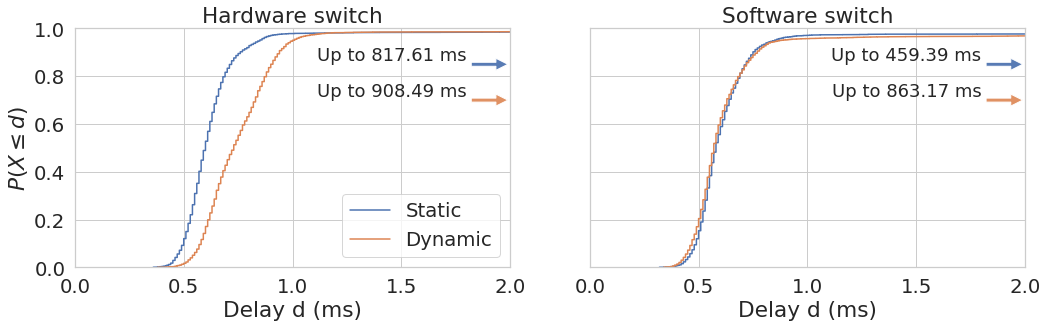

In [15]:
#CDF do ping
#Query
dfPingHW_CAPI = dfPing.query("Política == 'pi' and Tempo == '010' and Switch == 'HW'")
dfPingHW_CASW = dfPing.query("Política == 'sw' and Tempo == '010' and Switch == 'HW'")
dfPingSW_CAPI = dfPing.query("Política == 'pi' and Tempo == '010' and Switch == 'SW'")
dfPingSW_CASW = dfPing.query("Política == 'sw' and Tempo == '010' and Switch == 'SW'")
#HW
hw_a = dfPingHW_CAPI.Ping.to_numpy()
hw_b = dfPingHW_CASW.Ping.to_numpy()
maxHW = [hw_a.max(), hw_b.max()]
hw_x = np.sort(hw_a)
hw_x1 = np.sort(hw_b)
hw_ecdf = sm.distributions.ECDF(hw_a)
hw_ecdf1 = sm.distributions.ECDF(hw_b)
hw_y = hw_ecdf(hw_x)
hw_y1 = hw_ecdf1(hw_x1)
#SW
sw_a = dfPingSW_CAPI.Ping.to_numpy()
sw_b = dfPingSW_CASW.Ping.to_numpy()
maxSW = [sw_a.max(), sw_b.max()]
sw_x = np.sort(sw_a)
sw_x1 = np.sort(sw_b)
sw_ecdf = sm.distributions.ECDF(sw_a)
sw_ecdf1 = sm.distributions.ECDF(sw_b)
sw_y = sw_ecdf(sw_x)
sw_y1 = sw_ecdf1(sw_x1)
#Graficos
#HW
plt.subplot(1, 2, 1)
plt.step(hw_x, hw_y, where='post', label="Static")
plt.step(hw_x1, hw_y1, where='post', label="Dynamic")
plt.ylabel(r'$P(X \leq d)$')
plt.xlabel(r'Delay d (ms)')
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Hardware switch')
maiorPing = np.max(maxHW)
plt.annotate('Up to '+str(maxHW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85),size='small',
            arrowprops=dict(facecolor='#587bb4', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
plt.annotate('Up to '+str(maxHW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7),size='small',
            arrowprops=dict(facecolor='#e09163', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
#SW
plt.subplot(1, 2, 2)
plt.step(sw_x, sw_y, where='post', label="Static")
plt.step(sw_x1, sw_y1, where='post', label="Dynamic")
#plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Delay d (ms)')
plt.xlim(0, 2)
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Software switch')
#Tamanho
fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.tight_layout()
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])
maiorPing = np.max(maxSW)
plt.annotate('Up to '+str(maxSW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85), size='small',
            arrowprops=dict(facecolor='#587bb4', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
plt.annotate('Up to '+str(maxSW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7), size='small',
            arrowprops=dict(facecolor='#e09163', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
if (salvarGraficos):
    plt.savefig('Graficos/pingCargaHigh.pdf')
plt.show()